# _Exploratory Data Analysis of the Coimbra Breast Cancer data Data Set._

## Dataset Summary.

The dataset used in this project consists of anthropometric data and parameters gathered in a standard blood analysis. This dataset was created by Miguel Patrício, José Pereira, Joana Crisóstomo, Paulo Matafome, Raquel Seiça, Francisco Caramelo, all from the Faculty of Medicine of the University of Coimbra and also Manuel Gomes from the University Hospital Centre of Coimbra (Patrício et al., 2018). The dataset was sourced from the UCI Machine Learning Repository (Dua and Graff 2017) and it can be found [here](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Coimbra), particularly [this file](https://archive.ics.uci.edu/ml/machine-learning-databases/00451/dataR2.csv). Each row in this dataset represents a set of observations of individual patients and each column represents a variable. In this dataset, there are 116 observations and 9 features which are all numerical. There are zero observations with missing values for each class in the dataset. The target column is a binary dependent variable, which indicates the presence (Classification = 2) or absence (Classification = 1) of breast cancer.


### Exploratory Data Analysis checklist:

- Formulate the question
- Read in the data
- Check the packaging
- Look at the top and the bottom of your data
- Make a plot
- Follow up

### Formulate the Question: 

Given the clinical and anthropometric data available, predict if a patient have breast cancer or not?

## Load Required Packages

In [8]:
import matplotlib.pyplot as plt
import altair as alt
import numpy as np
import pandas as pd
import seaborn as sns

# Classifiers 
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression

# train test split and cross validation
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)

# Feature and model selection metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    plot_confusion_matrix,
)

# Preprocessing and pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    StandardScaler,
    normalize,
    scale,
)

## Read in the data and Check the packaging

In [2]:
bc_df = pd.read_csv("../data/raw/dataR2.csv")

bc_df

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1
...,...,...,...,...,...,...,...,...,...,...
111,45,26.850000,92,3.330,0.755688,54.6800,12.100000,10.96000,268.230,2
112,62,26.840000,100,4.530,1.117400,12.4500,21.420000,7.32000,330.160,2
113,65,32.050000,97,5.730,1.370998,61.4800,22.540000,10.33000,314.050,2
114,72,25.590000,82,2.820,0.570392,24.9600,33.750000,3.27000,392.460,2


### The Workflow to which we should adhere.

To avoid breaking the golden rule and hence optaining an optimistic estimate of our model's performance when computing scores (which is bad), we have decided to split our dataset before performing an exploratory data analysis.

In [3]:
train_df, test_df = train_test_split(bc_df, test_size = 0.2, random_state = 123)

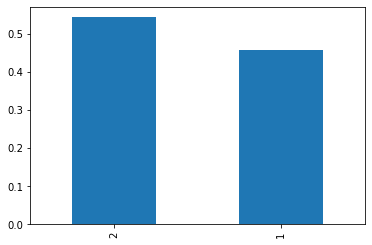

In [20]:
eda1 = train_df["Classification"].value_counts(normalize=True).plot(kind = 'bar').get_figure().savefig("figures/deado.png")

In [6]:
alt.Chart(train_df).mark_bar().encode(x = "Classification:N", y = "count()")

alt.Chart(...)

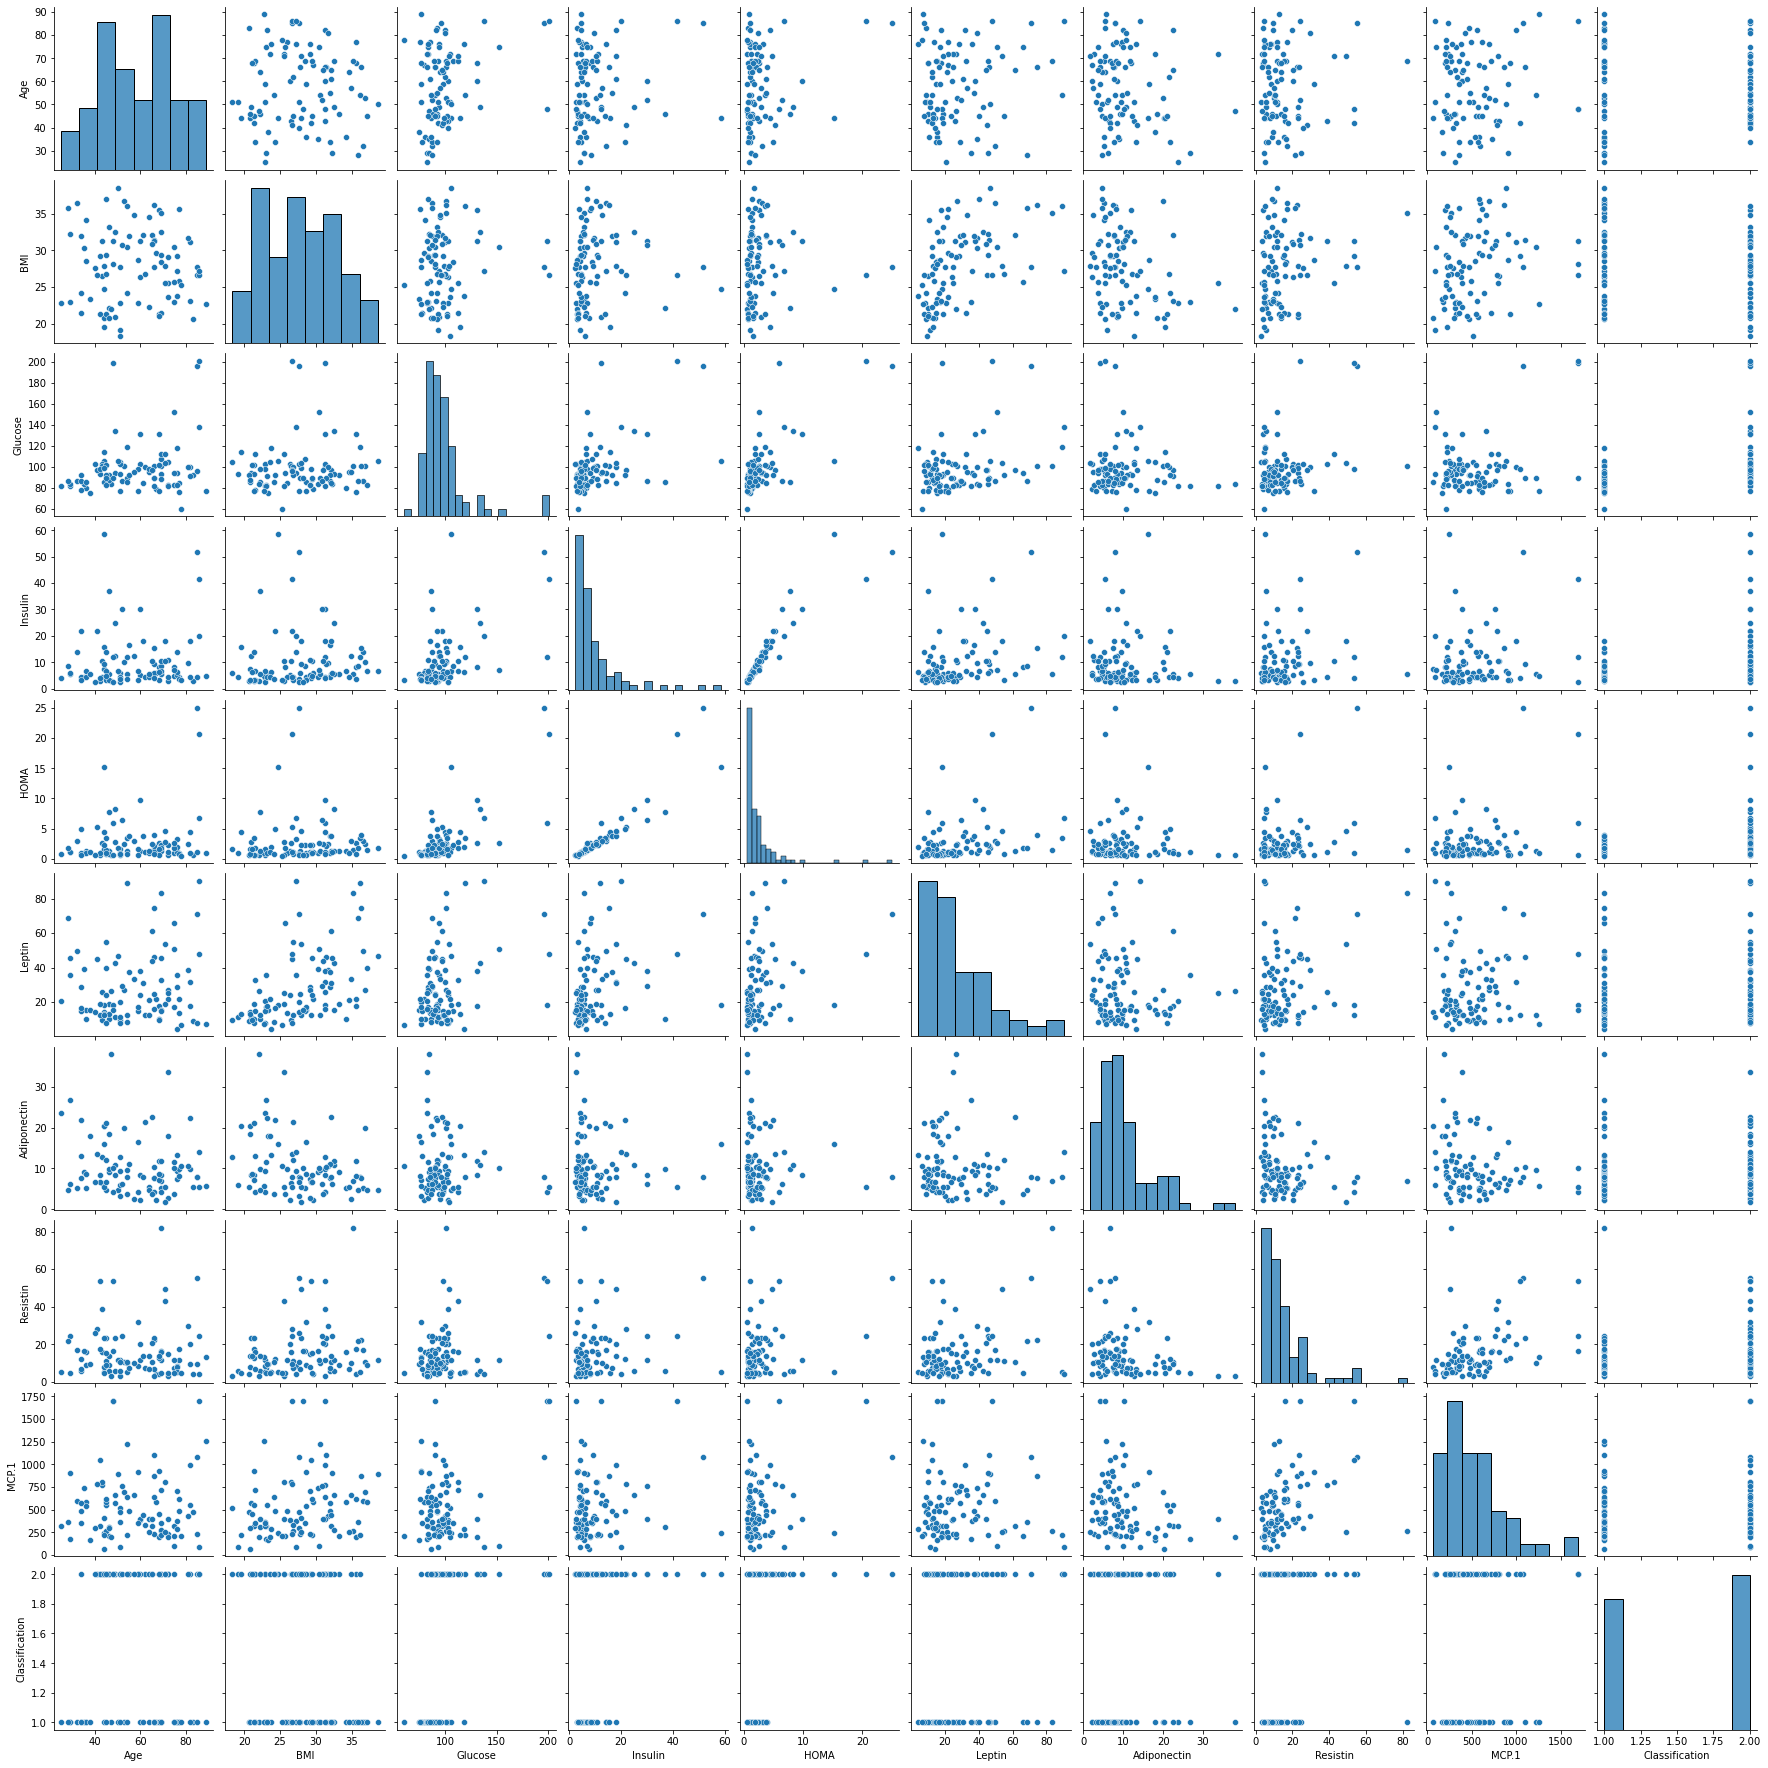

In [22]:
plot = sns.pairplot(train_df).savefig("./figures/leet.png")

In [17]:
plot.savefig("./figures/mine.png")

The class distribution is fairly balanced, therefore we do not need to worry about a class imbalance. 

In [ ]:
train_df.info()

In [5]:
train_df.to_csv('../data/raw/train.csv')

In [ ]:
"""author: Anene Ifeanyi and Rahul Kuriyedath, Help: Adithya and Saule Atymtayeva

date: 2020-11-25
This script imports the training data file and generates visualizations to explore the features.


Usage: generate_data.py --in_train_file=<in_train_path>  --figure_1=<figure_1> --figure_2=<figure_2>
Options:
--in_train_file=<in_train_path>      Path (including filename and extension) from which train file is chosen 
--figure_1=<figure_1>                Path (including filename and extension) of where to locally store the figures
--figure_2=<figure_2>                Path (including filename and extension) of where to locally store the figures

Example:
    python src/generate_data.py --data_path="data/processed/bank-additional-full_train.csv" --image_path="results/"

"""

from docopt import docopt
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import altair as alt
from altair_saver import save

alt.renderers.enable("mimetype")
alt.data_transformers.enable("data_server")

opt = docopt(__doc__)
alt.data_transformers.disable_max_rows()


train_df = pd.read_csv(opt["--in_train_file"])
plot = sns.pairplot(train_df)
plot2 = train_df["Classification"].value_counts(normalize=True).plot(kind='bar')


try:
    plot.savefig(opt["--figure_1"])
    plt.savefig(opt["--figure_2"])
except:
    os.mkdir("./figures/")
    plot.savefig(opt["--figure_1"])
    plt.savefig(opt["--figure_2"])

In [ ]:
train_df.describe(include = "all")

## Make Plots:

In [ ]:
features = train_df.drop(columns = ["Classification"]).select_dtypes(include = np.number)



for feat in features:
    eda_fig = plt.gcf()
    ax = train_df.groupby("Classification")[feat].plot.hist(bins = 20, alpha = 0.4, legend = True)
    plt.xlabel(feat)
    plt.title("Histogram of " + feat)
    plt.show()

eda_fig.savefig("../src/eda/figureeeeeee.png")

## Follow up:

Looking at the graphs developed above, there seems to be some interesting features (such as Glucose, Insulin, HOMA, and Resistin) which can be used to predict the presence or absence of breast cancer. Therefore, we plan on exploring classification evaluation metrics, developing a baseline model, exploring more complicated models, choosing a model based on our evaluation metrics, and performing hyperparameter optimization of the model.  

# Analysis 



In [ ]:
numeric_features = ["Glucose", "Insulin", "HOMA", "Resistin"]



In [ ]:
X_train = train_df.drop(columns = ["Classification"])
y_train = train_df["Classification"]


X_test = test_df.drop(columns = ["Classification"])
y_test = test_df["Classification"]

# Data Preprocessing

Given that we only have numerical features, therefore, we decided to create a machine learning pipeline that handles missing values and scales the numerical features, so that we can get appropriate results.

In [ ]:
numeric_transformer = make_pipeline(StandardScaler())

preprocessor = ColumnTransformer(
    transformers = [
        ("num", numeric_transformer, numeric_features)
    ]
)

In [ ]:
preprocessor.fit(X_train, y_train);

In [ ]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True)).mean()

In [ ]:
#pipe.fit(X_train, y_train)
#plot_confusion_matrix(pipe, X_train, y_train, display_labels=["Not Cancer", "Cancer"], values_format = "d", cmap=plt.cm.Blues);

In [ ]:
dummyPipe = Pipeline(
        steps = [
            ("preprocessor", preprocessor),
            ("baseline", DummyClassifier(strategy = "prior"))
        ]
)

dummyPipe.fit(X_train, y_train);

In [ ]:
results_dict = {}

In [ ]:
# Adapted from DSCI 571 Lectures

def store_cross_val_results(model_name, scores, results_dict):
    """
    Stores mean scores from cross_validate in results_dict for
    the given model model_name.

    Parameters
    ----------
    model_name :
        scikit-learn classification model
    scores : dict
        object return by `cross_validate`
    results_dict: dict
        dictionary to store results

    Returns
    ----------
        None

    """
    results_dict[model_name] = {
        "mean_train_accuracy": "{:0.4f}".format(np.mean(scores["train_score"])),
        "mean_validation_accuracy": "{:0.4f}".format(np.mean(scores["test_score"])),
        "mean_fit_time (s)": "{:0.4f}".format(np.mean(scores["fit_time"])),
        "mean_score_time (s)": "{:0.4f}".format(np.mean(scores["score_time"])),
        "std_train_score": "{:0.4f}".format(scores["train_score"].std()),
        "std_test_score": "{:0.4f}".format(scores["test_score"].std()),
    }

In [ ]:
scores = cross_validate(dummyPipe, X_train, y_train, return_train_score = True)

store_cross_val_results("DummyClf", scores, results_dict)

pd.DataFrame(results_dict).T

In [ ]:
models = {
    "decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(),
    "Logistic Regression": LogisticRegression(solver = 'liblinear'),
}

for model_name, model in models.items():
    
    opt_Pipe = Pipeline(
    
        steps = [("preprocessor", preprocessor),
                ("Classifier", model)]
    )
    
    scores_4_2 = cross_validate(opt_Pipe, X_train, y_train, return_train_score = True)

    store_cross_val_results(model_name, scores_4_2, results_dict)

In [ ]:
pd.DataFrame(results_dict).T 

# Regularization Hyperparameter Optimization 

Currently, we've attempted using a baseline model as a sanity check for our machine learning pipeline, and this model has the lowest accuracy. Furthermore, we attempted using the decision tree classifier, the K-nearest neighbours classifier and the Support Vector Machine classifier (SVM) with Radial Basis Functions (RBF) kernel. Initially, the support vector machine classifier, is doing the best job because it remembers only the key examples, however, the model seems to struggle on the validation split. Hence, we decided to optimize the hyperparameter.

In [ ]:

param_grid = {"C": np.logspace(-3, 2, 6)}

### END STARTER CODE

results_dict = {}

for c in param_grid["C"]:
    c_opt_Pipe = Pipeline(
        steps = [("preprocessor", preprocessor),
                ("Classifier", LogisticRegression(solver = 'liblinear'))]
    )
    
    scores_opt = cross_validate(c_opt_Pipe, X_train, y_train, return_train_score = True)

    store_cross_val_results(f"LogisticRegression C = {c}", scores_opt, results_dict)

In [ ]:
pd.DataFrame(results_dict)

# _References_

Patrício, M., Pereira, J., Crisóstomo, J., Matafome, P., Gomes, M., Seiça, R. and Caramelo, F., 2018. Using Resistin, glucose, age and BMI to predict the presence of breast cancer. BMC Cancer, 18(1). https://doi.org/10.1186/s12885-017-3877-1

Dua, Dheeru, and Casey Graff. 2017. “UCI Machine Learning Repository.” University of California, Irvine, School of Information; Computer Sciences. http://archive.ics.uci.edu/ml.